# HW 4

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## 1. SNPs of World-wide populations

In [2]:
snp_df = pd.read_csv('ceph_hgdp_minor_code_XNA.betterAnnotated.csv')
sinfo_df = pd.read_csv('ceph_hgdp_minor_code_XNA.sampleInformation.csv')

print(snp_df.head())
print(sinfo_df.head())

          snp  chr        pos  HGDP00448  HGDP00479  HGDP00985  HGDP01094   
0  rs10000929    4  131516474          1          0          0          1  \
1  rs10002472    4  159087423          2          1          2          2   
2  rs10005550    4  128697858          2          2          2          2   
3  rs10007576    4   59063992          2          0          2          1   
4  rs10007998    4   35988597          0          0          0          0   

   HGDP00982  HGDP00911  HGDP01202  ...  HGDP01342  HGDP00824  HGDP01319   
0          1          0          1  ...          1          0          1  \
1          0          2          2  ...          2          2          2   
2          1          0          1  ...          2          2          2   
3          2          2          2  ...          2          1          2   
4          0          0          0  ...          2          1          2   

   HGDP01357  HGDP00549  HGDP00953  HGDP01070  HGDP01376  HGDP00671  HGDP01024  

In [3]:
X = snp_df.drop(['snp','chr','pos'],axis=1).values
X = np.array(X)
p, n = X.shape
print(p, n)

regions = sinfo_df['region']

488919 1043


In [33]:
def MDS(X, k):
    n = X.shape[1]
    H = np.eye(n) - np.ones((n, n))/n # H: (n, n)
    K = (X.dot(H)).T.dot((X.dot(H))) # X: (k, n), XH: (k, n), K: (n, n)
    eigenvalues, eigenvectors = np.linalg.eigh(K)
    idx = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]
    Z = eigenvectors[:, :k].dot(np.diag(np.sqrt(eigenvalues[:k])))
    return Z, eigenvalues, eigenvectors

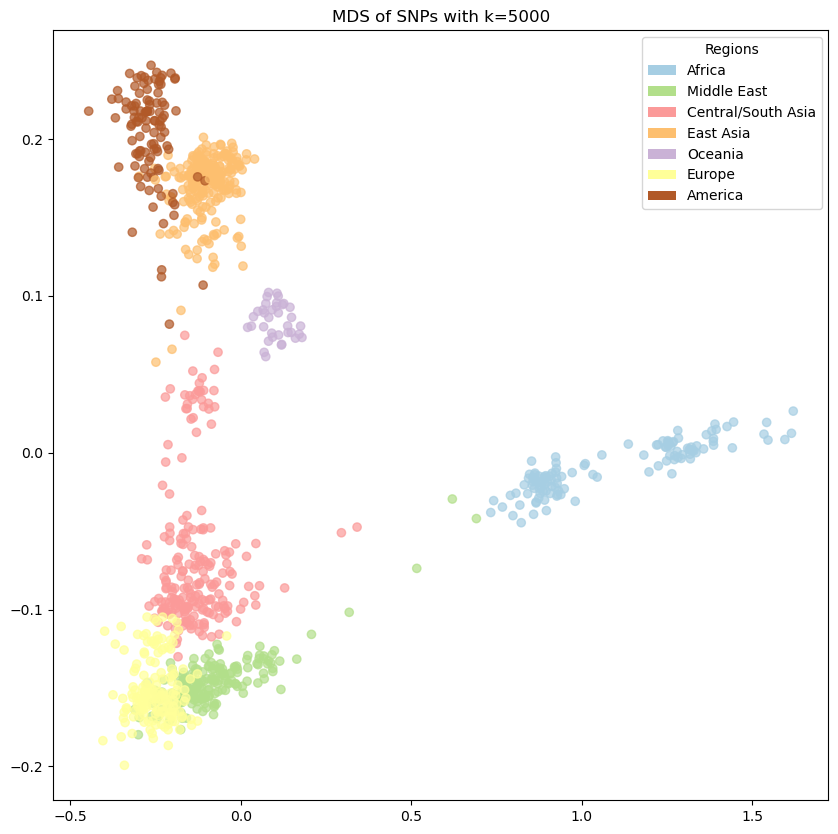

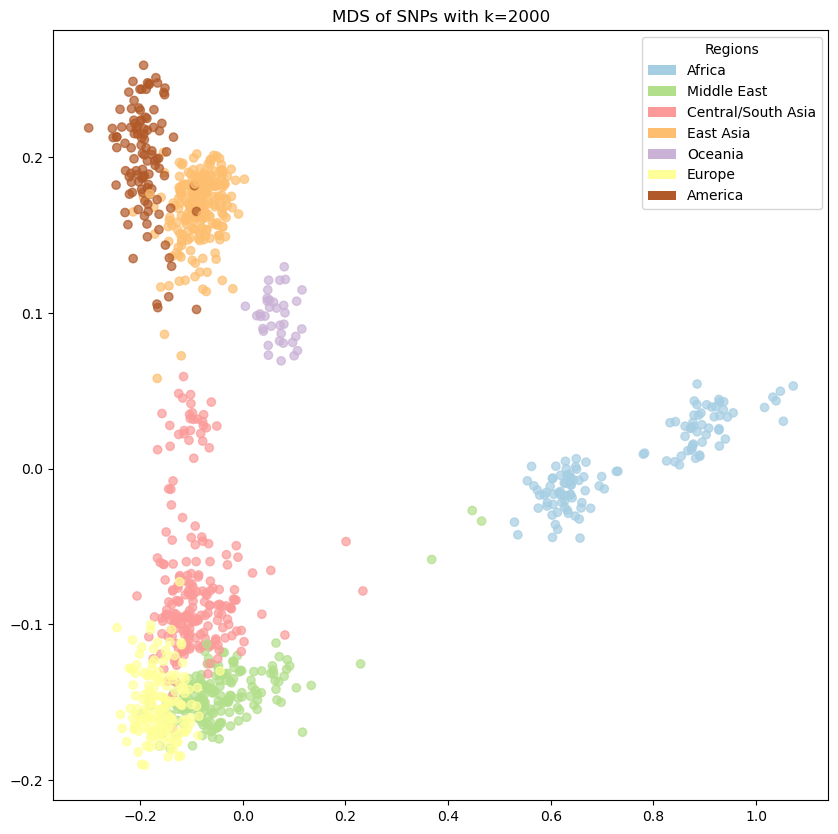

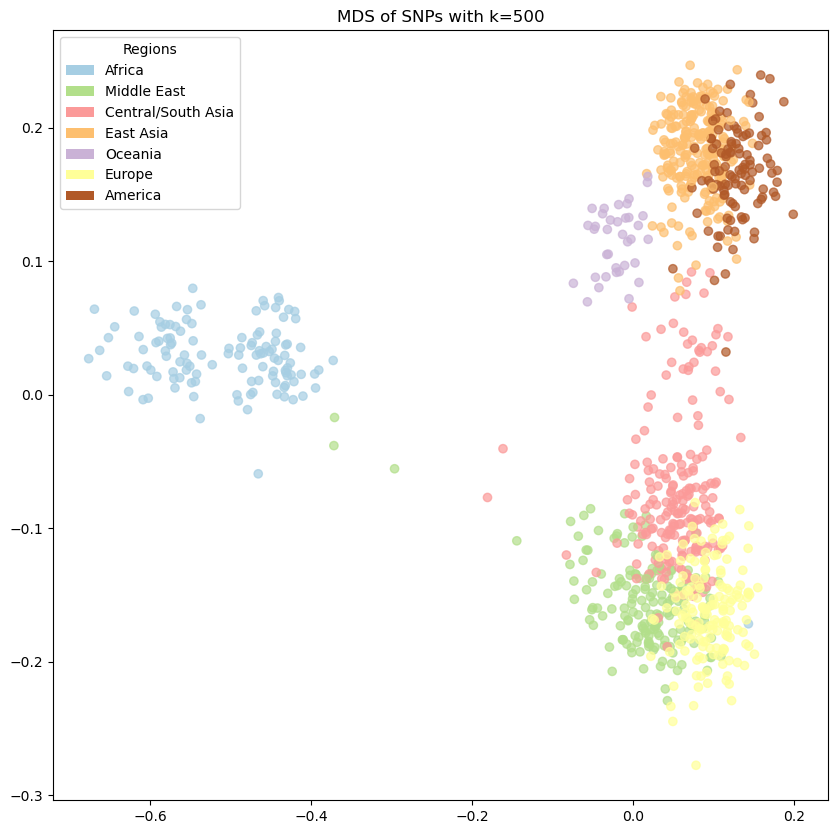

In [34]:
# Random projection matrix
# Get unique regions and assign a color to each
regions_unique = regions.unique()
colors = plt.cm.Paired(np.linspace(0, 1, len(regions_unique)))

# Map each region to a color
color_map = {region: colors[i] for i, region in enumerate(regions_unique)}
# Get a list of colors for each point in Z
point_colors = [color_map[region] for region in regions]

np.random.seed(1)
for k in [5000, 2000, 500]:  #
    R = np.zeros((k,p))
    for i in range(k):
        j_rand = np.random.randint(0,p, size=k)
        R[i,j_rand] = 1/k

    X_p = R.dot(X)  # (p, n) -> (k, n)
    Z, eigenvalues, eigenvectors = MDS(X_p, 2)
    regions_unique = regions.unique()

    plt.figure(figsize=(10, 10))
    plt.scatter(Z[:, 0], Z[:, 1], color=point_colors, alpha=0.7)

    # Create a custom legend
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor=color_map[region], label=region) for region in regions_unique]
    plt.legend(handles=legend_elements, title="Regions")
    plt.title(f'MDS of SNPs with k={k}')

    plt.show()

## 2. Phase Transition in Compressed Sensening

A:\Academic\anaconda3\envs\dl\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


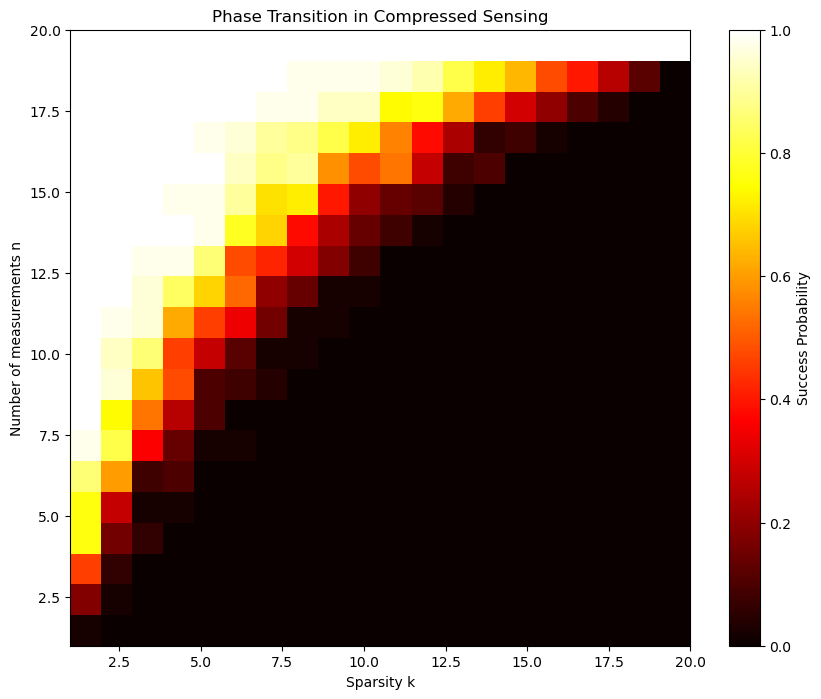

In [2]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt

d = 20
n_trials = 50

# Prepare to store the success probabilities
success_prob = np.zeros((d, d))

# Loop over each dimension n and sparsity k
for n in range(1, d + 1):
    for k in range(1, d + 1):
        success_count = 0

        for _ in range(n_trials):
            # (a): Create a sparse vector x0 with k nonzeros
            x0 = np.zeros(d)
            indices = np.random.choice(d, k, replace=False)
            x0[indices] = np.random.choice([-1, 1], k)

            # (b): Generate Gaussian random matrix A and compute b = Ax0
            A = np.random.randn(n, d)
            b = A @ x0

            # (c): Solve the L1 minimization problem
            x = cp.Variable(d)
            objective = cp.Minimize(cp.norm(x, 1))
            constraints = [A @ x == b]
            problem = cp.Problem(objective, constraints)
            problem.solve()

            # (d): Threshold
            if np.linalg.norm(x.value - x0, 2) < 1e-3:
                success_count += 1

        # Store the success probability for this (n, k)
        success_prob[n-1, k-1] = success_count / n_trials

# Plotting the results
plt.figure(figsize=(10, 8))
plt.imshow(success_prob, origin='lower', cmap='hot', extent=(1, d, 1, d), aspect='auto')
plt.colorbar(label='Success Probability')
plt.xlabel('Sparsity k')
plt.ylabel('Number of measurements n')
plt.title('Phase Transition in Compressed Sensing')
plt.show()

Jus as the Theoretical work suggested, like the papers by Tropp, the expriment shows that there exists a transition between the values of n and where successful recovery of x0 from b become unlikely form likeky. High success probability is observed in the region where n > 2k. Compressed sensing theory predicts that successful recovery is likely if n>=Cklog(d/k) f(C is a constant), which since match the experimental results.